## EEG Classification CNN ML Model (Control vs Schizophrenia)

Graph-based analysis of brain connectivity in schizophrenia - Elzbieta Olejarczyk , Wojciech Jernajczyk
Research Paper:  https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0188629
Dataset:         https://repod.icm.edu.pl/dataset.xhtml?persistentId=doi:10.18150/repod.0107441

In [25]:
%pip install mne

In [26]:
# Necessary Imports

from glob import glob # Read files from folder
import os # Operating System interfaces

import mne # Analyze EEG data

import numpy as np # Calculations
import pandas as pd # Dataframes

import matplotlib.pyplot as plt # Plotting and Visualizations

from scipy import stats # statistical calculations - scientific data

from sklearn.linear_model import LogisticRegression # Logistic Regression for Features array
from sklearn.pipeline import Pipeline # Use a pipeline of our scaling for classification purpose
from sklearn.preprocessing import StandardScaler # Use standar scaler for classification preprocessing
from sklearn.model_selection import GroupKFold # Use KFold for groups(control vs schizophrenic)
from keras.utils import plot_model
from sklearn.model_selection import GridSearchCV # Hyperparameter Tuning - Speed up performance
from sklearn.model_selection import LeaveOneGroupOut # Ability to exclude a group

# TensorFlow Keras Imports
from keras.layers import Conv1D, BatchNormalization, LeakyReLU, MaxPool1D,\
    GlobalAveragePooling1D, Dense, Dropout, AveragePooling1D
from keras.models import Sequential
from keras.backend import clear_session

In [27]:
# Access all edf files from directory
all_file_path = glob('phase_1_data/*.edf')
# all_file_path = glob('phase_1_data/*.edf')
#all_file_path

In [28]:
# Use list comprehension to split into healthy and patient file paths
# In Data: h ~ healthy ; s ~ schizophrenia
#[print(i.split('/')[1]) for i in all_file_path]
if all_file_path == glob('warsaw/*.edf'):
    healthy_file_path = [i for i in all_file_path if 'h' in i.split('/')[1]]
    patient_file_path = [i for i in all_file_path if 's' in i.split('/')[1]]

else:
    healthy_file_path = [i for i in all_file_path if 'h_' in i.split('/')[1]]
    patient_file_path = [i for i in all_file_path if 's_' in i.split('/')[1]]



In [29]:
healthy_file_path

['phase_1_data/h_44_Phase 1_1.edf',
 'phase_1_data/h_37_Phase 1_3.edf',
 'phase_1_data/h_46_Phase 1_1.edf',
 'phase_1_data/h_17_Phase 1.edf',
 'phase_1_data/h_33_Phase 1_4.edf',
 'phase_1_data/h_38_Phase 1.edf',
 'phase_1_data/h_38_Phase 1_1.edf',
 'phase_1_data/h_37_Phase 1_1.edf',
 'phase_1_data/h_24_Phase 1.edf',
 'phase_1_data/h_33_Phase 1_3.edf',
 'phase_1_data/h_33_Phase 1.edf',
 'phase_1_data/h_35_Phase 1_1.edf',
 'phase_1_data/h_28_Phase 1_1.edf',
 'phase_1_data/h_34_Phase 1_1.edf',
 'phase_1_data/h_17_Phase 1_1.edf',
 'phase_1_data/h_35_Phase 1_2.edf',
 'phase_1_data/h_66_Phase 1_1.edf',
 'phase_1_data/h_33_Phase 1_6.edf',
 'phase_1_data/h_34_Phase 1.edf',
 'phase_1_data/h_30_Phase 1_1.edf',
 'phase_1_data/h_30_Phase 1.edf',
 'phase_1_data/h_11_Phase 1.edf',
 'phase_1_data/h_11_Phase 1_1.edf',
 'phase_1_data/h_31_Phase 1_1.edf',
 'phase_1_data/h_43_Phase 1.edf',
 'phase_1_data/h_26_Phase 1_1.edf',
 'phase_1_data/h_29_Phase 1.edf',
 'phase_1_data/h_45_Phase 1.edf',
 'phase_1_da

In [30]:
patient_file_path

['phase_1_data/s_41_Phase 1.edf',
 'phase_1_data/s_71_Phase 1_1.edf',
 'phase_1_data/s_60_Phase 1_1.edf',
 'phase_1_data/s_7_Phase 1_1.edf',
 'phase_1_data/s_64_Phase 1_2.edf',
 'phase_1_data/s_20_Phase 1_1.edf',
 'phase_1_data/s_40_Phase 1_2.edf',
 'phase_1_data/s_72_Phase 1.edf',
 'phase_1_data/s_59_Phase 1_2.edf',
 'phase_1_data/s_16_Phase 1_1.edf',
 'phase_1_data/s_52_Phase 1_2.edf',
 'phase_1_data/s_22_Phase 1_1.edf',
 'phase_1_data/s_39_Phase 1_1.edf',
 'phase_1_data/s_73_Phase 1_3.edf',
 'phase_1_data/s_42_Phase 1_1.edf',
 'phase_1_data/s_56_Phase 1.edf',
 'phase_1_data/s_67_Phase 1.edf',
 'phase_1_data/s_15_Phase 1_1.edf',
 'phase_1_data/s_65_Phase 1_2.edf',
 'phase_1_data/s_48_Phase 1_2.edf',
 'phase_1_data/s_14_Phase 1.edf',
 'phase_1_data/s_57_Phase 1.edf',
 'phase_1_data/s_15_Phase 1.edf',
 'phase_1_data/s_4_Phase 1_2.edf',
 'phase_1_data/s_78_Phase 1_3.edf',
 'phase_1_data/s_9_Phase 1.edf',
 'phase_1_data/s_50_Phase 1_2.edf',
 'phase_1_data/s_78_Phase 1_2.edf',
 'phase_1_d

In [31]:
# Print file path lengths
print("all_file_path length:",len(all_file_path))
print('healthy_file_path length: ',len(healthy_file_path))
print('patient_file_path length: ',len(patient_file_path))

all_file_path length: 192
healthy_file_path length:  58
patient_file_path length:  134


In [32]:
# Function to read data from file paths
def read_data(file_path):
    # Read in raw edf data from path
    data = mne.io.read_raw_edf(file_path, preload=True)

    # Define eeg references - use default - average of all channels as reference for other channels
    data.set_eeg_reference()

    # Filter data based on low and high frequency (in Hz)
    #data.filter(l_freq=0.5, h_freq=45)

    # Convert data into epochs(segments), pass in data, signal duartion (5 secs), add overlap of segments
    epochs = mne.make_fixed_length_epochs(data, duration=5, overlap=1)

    # Create array from epochs data
    array = epochs.get_data()

    return array

In [33]:
# Sample example data for 1 healhy participant
#sample_data = read_data(healthy_file_path[0])

In [34]:
#sample_data.shape
# shape = (# of epochs, # of channels, length of signal)

In [35]:
%%capture
# Add this %%capture at top of cell to avoid printing all the data
# Read data and define epochs array for healthy control and schizoprenic patient
control_epochs_array = [read_data(i) for i in healthy_file_path]
patient_epochs_array = [read_data(i) for i in patient_file_path]

In [36]:
# Print epoch array shape
#print("control_epochs_array shape:", control_epochs_array[0].shape, control_epochs_array[1].shape)
#print("patient_epochs_array shape:", patient_epochs_array[0].shape, patient_epochs_array[1].shape)

In [37]:
# Create labels for control and patient epoch arrays
control_epochs_labels = [len(i)*[0] for i in control_epochs_array]
patient_epochs_labels = [len(i)*[1] for i in patient_epochs_array]
len(control_epochs_labels), len(patient_epochs_array)

(58, 134)

In [38]:
# combine both epochs array lists into a signal array list
epochs_array = control_epochs_array + patient_epochs_array

# combine labels
epochs_labels = control_epochs_labels + patient_epochs_labels

In [39]:
# Split data on basis of subjects(participants), Not on the basis of trials or epochs
group_list = [[i]*len(j) for i, j in enumerate(epochs_array)]
print(f"group_list length: {len(group_list)}")

group_list length: 192


In [40]:
# Convert lists into arrays
data_array = np.vstack(epochs_array)
label_array = np.hstack(epochs_labels)
group_array = np.hstack(group_list)

print(data_array.shape, label_array.shape, group_array.shape)

(240, 24, 1000) (240,) (240,)


#### Feature Extraction Functions

#### Deep Learning CNN

In [41]:
# Modify shape of data for CNN

# First convert data to numpy array
epochs_array = np.vstack(epochs_array)
epochs_labels = np.hstack(epochs_labels)
groups_array = np.hstack(group_list)

In [42]:
# Check shape for each array
print(epochs_array.shape)
print(epochs_labels.shape)
print(groups_array.shape)

# 7201 - # of segments, 19 - # of channels, 1250 - length

(240, 24, 1000)
(240,)
(240,)


In [43]:
# In epoch array - move axis of channel to the end
epochs_array = np.moveaxis(epochs_array,1,2)
epochs_array.shape

(240, 1000, 24)

In [44]:
# from keras.layers import Input, Dense, Conv2D, BatchNormalization, LeakyReLU, MaxPooling2D, GlobalAveragePooling2D, Dropout, Concatenate, UpSampling2D
# from keras.models import Model
# from keras.regularizers import l2
# from keras.optimizers import Adam
# from keras.callbacks import LearningRateScheduler
# import keras.backend as K
# import tensorflow as tf

# # Example learning rate schedule function
# def lr_schedule(epoch, lr):
#     if epoch < 10:
#         return lr
#     else:
#         return lr * K.exp(-0.1)

# def irregular_conv2d(inputs, filters, kernel_sizes, padding='same', kernel_regularizer=None):
#     outputs = []
#     for kernel_size in kernel_sizes:
#         conv = Conv2D(filters, kernel_size, padding=padding, kernel_regularizer=kernel_regularizer)(inputs)
#         outputs.append(conv)
#     return Concatenate(axis=-1)(outputs)

# def sequential_multi_resolution_branch_inc(inputs, filters):
#     conv1 = Conv2D(filters, kernel_size=(3, 3), padding='same')(inputs)
#     conv1 = BatchNormalization()(conv1)
#     conv1 = LeakyReLU()(conv1)

#     conv2 = Conv2D(filters*2, kernel_size=(5, 5), padding='same')(conv1)
#     conv2 = BatchNormalization()(conv2)
#     conv2 = LeakyReLU()(conv2)

#     return conv2

# def sequential_multi_resolution_branch_inc_dec(inputs, filters):
#     conv1 = Conv2D(filters, kernel_size=(3, 3), padding='same')(inputs)
#     conv1 = BatchNormalization()(conv1)
#     conv1 = LeakyReLU()(conv1)

#     conv2 = Conv2D(filters*2, kernel_size=(5, 5), padding='same')(conv1)
#     conv2 = BatchNormalization()(conv2)
#     conv2 = LeakyReLU()(conv2)

#     conv3 = Conv2D(filters, kernel_size=(3, 3), padding='same')(conv2)
#     conv3 = BatchNormalization()(conv3)
#     conv3 = LeakyReLU()(conv3)

#     return conv3

# def cnn_model_with_2d_and_koopman():
#     with tf.device('/gpu:1'):
#         if all_file_path == glob('warsaw/*.edf'):
#             input_shape = (1250, 19, 1)  # Example input shape for 2D ConvNet, adjust based on your data
#         else:
#             input_shape = (1000, 24, 1)  # Example input shape for 2D ConvNet, adjust based on your data

#         inputs = Input(shape=input_shape)

#         # Large-scale dynamics branch
#         #large_scale = irregular_conv2d(inputs, filters=32, kernel_sizes=[(24, 24), (24,12), (24,3)], padding='same', kernel_regularizer=l2(0.005))
#         large_scale = irregular_conv2d(inputs, filters=16, kernel_sizes=[(19, 19), (15,15), (11,11)], padding='same')
#         large_scale = BatchNormalization()(large_scale)
#         large_scale = LeakyReLU()(large_scale)

#         # Small-scale dynamics branch
#         #small_scale = irregular_conv2d(inputs, filters=32, kernel_sizes=[(3, 3),(3,5), (3,9)], padding='same', kernel_regularizer=l2(0.005))
#         small_scale = irregular_conv2d(inputs, filters=16, kernel_sizes=[(3, 3),(5,5), (7,7)], padding='same')
#         small_scale = BatchNormalization()(small_scale)
#         small_scale = LeakyReLU()(small_scale)

#         # Sequential multi-resolution branch (increasing filter sizes)
#         seq_multi_res_inc = sequential_multi_resolution_branch_inc(inputs, filters=16)

#         # Sequential multi-resolution branch (increasing and decreasing filter sizes)
#         #seq_multi_res_inc_dec = sequential_multi_resolution_branch_inc_dec(inputs, filters=16)

#         # Concatenate all branches
#         #x = Concatenate(axis=-1)([large_scale, small_scale, seq_multi_res_inc, seq_multi_res_inc_dec])

#         x = Concatenate(axis=-1)([large_scale, small_scale, seq_multi_res_inc])
#         # Placeholder for Koopman Embedding Layer equivalent for 2D (conceptual, needs actual implementation)
#         # x = KoopmanEmbeddingLayer2D(num_eigenfunctions=128)(x)

#         # More layers following the initial embedding
#         x = MaxPooling2D(pool_size=(2, 2))(x)
#         #x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.01))(x)
#         x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.05))(x)
#         x = BatchNormalization()(x)
#         x = LeakyReLU()(x)

#         x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.05))(x)
#         x = BatchNormalization()(x)
#         x = LeakyReLU()(x)

#         x = GlobalAveragePooling2D()(x)
#         x = Dense(16, activation='relu')(x)
#         x = Dropout(0.5)(x)
#         outputs = Dense(1, activation='sigmoid')(x)

#         model = Model(inputs=inputs, outputs=outputs)

#         # Compile model with a variable learning rate
#         optimizer = Adam(learning_rate=0.0005)  # Starting learning rate
#         model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

#         return model, LearningRateScheduler(lr_schedule)

# # Create the model and get the LearningRateScheduler
# model, lr_scheduler = cnn_model_with_2d_and_koopman()
# #model.summary()
# plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

# # Example of how to fit the model with the learning rate scheduler
# # model.fit(X_train, Y_train, epochs=50, callbacks=[lr_scheduler])

In [45]:
# Define group k fold
gkf = GroupKFold(n_splits=5)

In [46]:
# List to store accuracy from each fold
accuracy=[]

In [47]:
#print(train_features.shape)
#print(val_features.shape)

In [48]:
# # Iterate through train_index and val_index
# for train_index, val_index in gkf.split(epochs_array, epochs_labels, groups=groups_array):
#     # Define training and validation features + lables
#     train_features, train_labels = epochs_array[train_index], epochs_labels[train_index]
#     val_features, val_labels = epochs_array[val_index],epochs_labels[val_index]

#     # Convert data from 3D to 2D for Scaling and Normalization
#     # (5744, 1250, 19) -> (5744 * 1250, 19)
#     # And then re-shape back to 3D
#     scaler = StandardScaler()
#     train_features = scaler.fit_transform\
#         (train_features.reshape(-1,train_features.shape[-1])).reshape(train_features.shape)
#     val_features = scaler.fit_transform\
#         (val_features.reshape(-1,val_features.shape[-1])).reshape(val_features.shape)


#     #input_shape = (1 ,1000,24)
#     # Call and fit model
#     #model = cnn_model_with_2d_and_koopman()
#     model, lr_scheduler = cnn_model_with_2d_and_koopman()

#     model.fit(train_features, train_labels, epochs=500, batch_size=32,
#               validation_data=(val_features, val_labels))

#     # Append model accuracy to list
#     accuracy.append(model.evaluate(val_features, val_labels)[1])
#     print(accuracy)
#     break

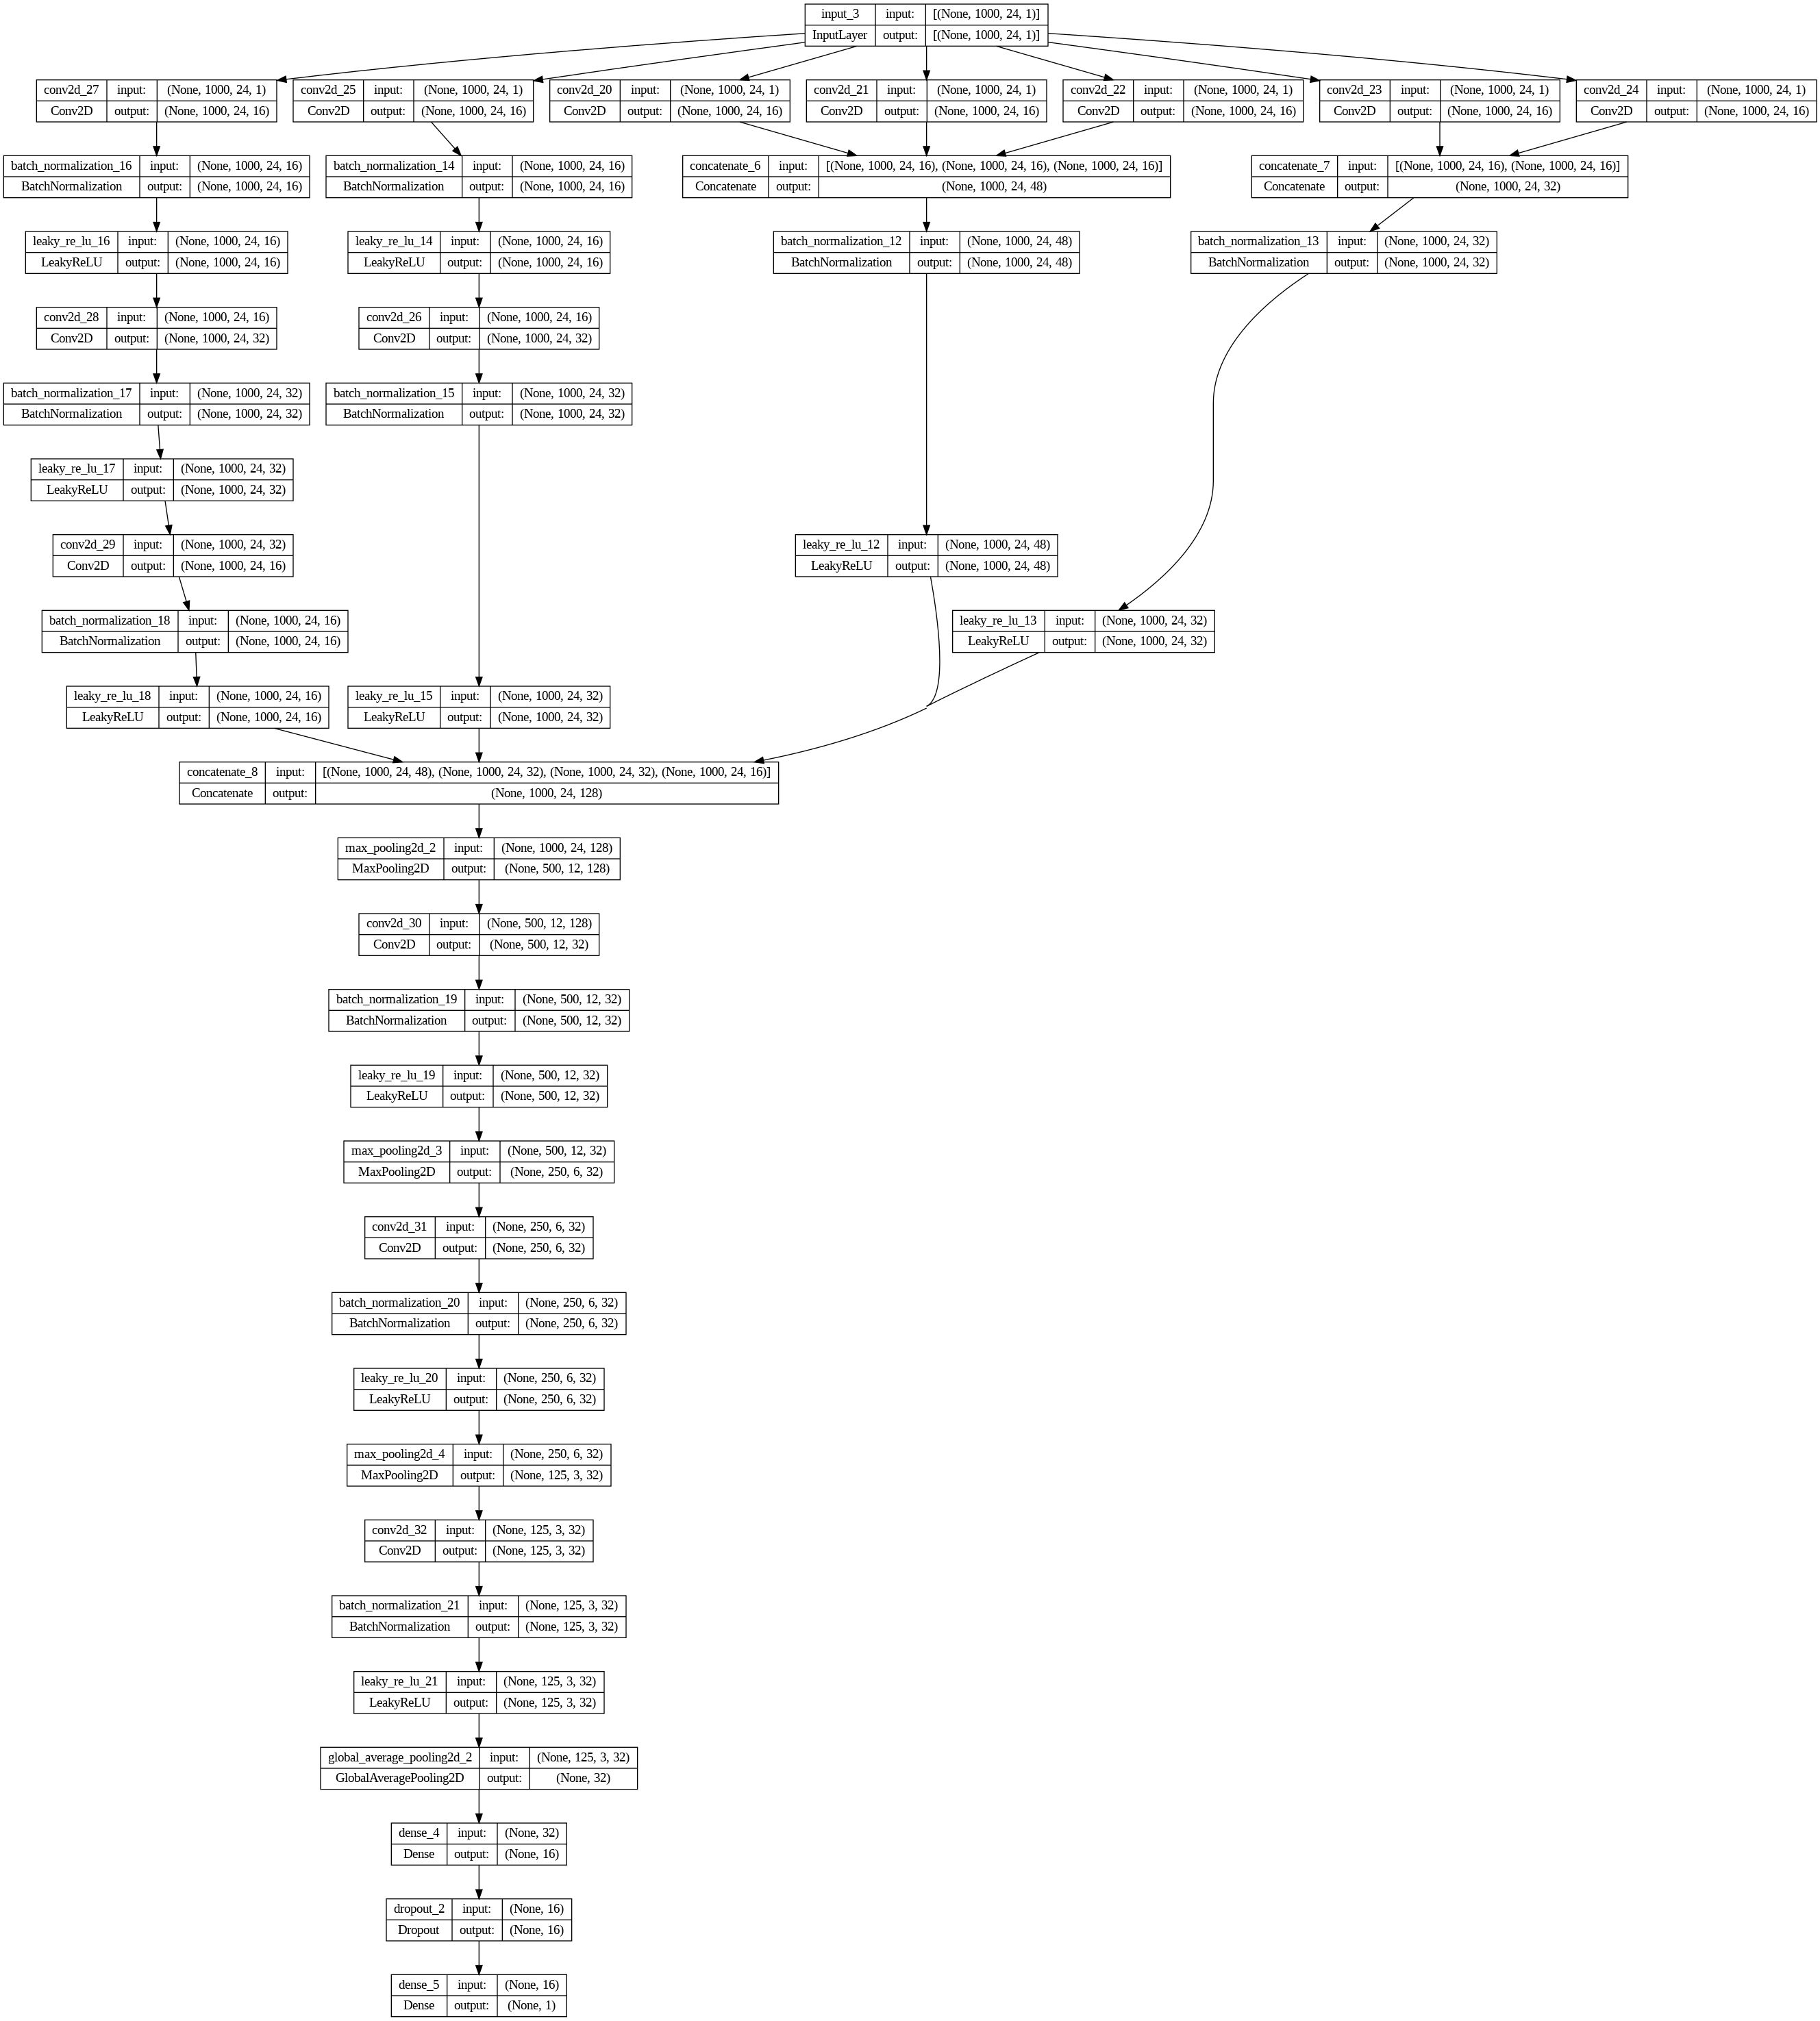

In [49]:
from keras.layers import Input, Dense, Conv2D, BatchNormalization, LeakyReLU, MaxPooling2D, GlobalAveragePooling2D, Dropout, Concatenate, UpSampling2D
from keras.models import Model
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
import keras.backend as K
import tensorflow as tf

# Example learning rate schedule function
def lr_schedule(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * K.exp(-0.1)

def irregular_conv2d(inputs, filters, kernel_sizes, padding='same', kernel_regularizer=None):
    outputs = []
    for kernel_size in kernel_sizes:
        conv = Conv2D(filters, kernel_size, padding=padding, kernel_regularizer=kernel_regularizer)(inputs)
        outputs.append(conv)
    return Concatenate(axis=-1)(outputs)

def sequential_multi_resolution_branch_inc(inputs, filters):
    conv1 = Conv2D(filters, kernel_size=(3, 3), padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = LeakyReLU()(conv1)

    conv2 = Conv2D(filters*2, kernel_size=(5, 5), padding='same')(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = LeakyReLU()(conv2)

    return conv2

def sequential_multi_resolution_branch_inc_dec(inputs, filters):
    conv1 = Conv2D(filters, kernel_size=(3, 3), padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = LeakyReLU()(conv1)

    conv2 = Conv2D(filters*2, kernel_size=(5, 5), padding='same')(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = LeakyReLU()(conv2)

    conv3 = Conv2D(filters, kernel_size=(3, 3), padding='same')(conv2)
    conv3 = BatchNormalization()(conv3)
    conv3 = LeakyReLU()(conv3)

    return conv3

def cnn_model_with_2d_and_koopman():
    with tf.device('/gpu:1'):
        if all_file_path == glob('warsaw/*.edf'):
            input_shape = (1250, 19, 1)  # Example input shape for 2D ConvNet, adjust based on your data
        else:
            input_shape = (1000, 24, 1)  # Example input shape for 2D ConvNet, adjust based on your data

        inputs = Input(shape=input_shape)

        # Large-scale dynamics branch
        large_scale = irregular_conv2d(inputs, filters=16, kernel_sizes=[(19, 19),(19,7),(19, 3)], padding='same', kernel_regularizer=l2(0.01))
        large_scale = BatchNormalization()(large_scale)
        large_scale = LeakyReLU()(large_scale)

        # Small-scale dynamics branch
        small_scale = irregular_conv2d(inputs, filters=16, kernel_sizes=[(3, 3), (3, 7)], padding='same', kernel_regularizer=l2(0.01))
        small_scale = BatchNormalization()(small_scale)
        small_scale = LeakyReLU()(small_scale)

        # Sequential multi-resolution branch (increasing filter sizes)
        seq_multi_res_inc = sequential_multi_resolution_branch_inc(inputs, filters=16)

        # Sequential multi-resolution branch (increasing and decreasing filter sizes)
        seq_multi_res_inc_dec = sequential_multi_resolution_branch_inc_dec(inputs, filters=16)

        # Concatenate all branches
        x = Concatenate(axis=-1)([large_scale, small_scale, seq_multi_res_inc, seq_multi_res_inc_dec])

        # Placeholder for Koopman Embedding Layer equivalent for 2D (conceptual, needs actual implementation)
        # x = KoopmanEmbeddingLayer2D(num_eigenfunctions=128)(x)

        # More layers following the initial embedding
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.01))(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.01))(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.01))(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        x = GlobalAveragePooling2D()(x)
        x = Dense(16, activation='relu')(x)
        x = Dropout(0.5)(x)
        outputs = Dense(1, activation='sigmoid')(x)

        model = Model(inputs=inputs, outputs=outputs)

        # Compile model with a variable learning rate
        optimizer = Adam(learning_rate=0.00005)  # Starting learning rate
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

        return model, LearningRateScheduler(lr_schedule)

# Create the model and get the LearningRateScheduler
model, lr_scheduler = cnn_model_with_2d_and_koopman()
#model.summary()
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

# Example of how to fit the model with the learning rate scheduler
# model.fit(X_train, Y_train, epochs=50, callbacks=[lr_scheduler])

In [51]:
# Iterate through train_index and val_index
for train_index, val_index in gkf.split(epochs_array, epochs_labels, groups=groups_array):
    # Define training and validation features + lables
    train_features, train_labels = epochs_array[train_index], epochs_labels[train_index]
    val_features, val_labels = epochs_array[val_index],epochs_labels[val_index]

    # Convert data from 3D to 2D for Scaling and Normalization
    # (5744, 1250, 19) -> (5744 * 1250, 19)
    # And then re-shape back to 3D
    scaler = StandardScaler()
    train_features = scaler.fit_transform\
        (train_features.reshape(-1,train_features.shape[-1])).reshape(train_features.shape)
    val_features = scaler.fit_transform\
        (val_features.reshape(-1,val_features.shape[-1])).reshape(val_features.shape)


    #input_shape = (1 ,1000,24)
    # Call and fit model
    #model = cnn_model_with_2d_and_koopman()
    model, lr_scheduler = cnn_model_with_2d_and_koopman()

    model.fit(train_features, train_labels, epochs=750, batch_size=32,
              validation_data=(val_features, val_labels))

    # Append model accuracy to list
    accuracy.append(model.evaluate(val_features, val_labels)[1])
    print(accuracy)
    break

Epoch 1/750
3/6 [==============>...............] - ETA: 1:08 - loss: 2.1137 - accuracy: 0.3438

KeyboardInterrupt: 

In [ ]:
print(train_features.reshape(-1, train_features.shape[-1]).shape)

In [ ]:
# Save Model Weights
model.save_weights("Schizophrenia_CNN_Weights")